/home/user/anaconda3/envs/deme-ghost/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/anaconda3/envs/deme-ghost/lib/python3.10/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[04:05:58] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[04:05:58] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[04:05:58] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.


Faces found:  1
Faces found:  1
Bad source images
Faces found:  2
[array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [29, 26, 29],
        [30, 27, 29],
        [30, 27, 29]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [29, 27, 29],
        [29, 28, 30],
        [29, 28, 30]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [28, 27, 29],
        [29, 28, 30],
        [29, 28, 30]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [12,  1,  0],
        [13,  1,  0],
        [13,  1,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [12,  1,  0],
        [13,  1,  0],
        [13,  1,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [12,  1,  0],
        [13,  1,  0],
        [13,  1,  0]]], dtype=uint8), array([[[  0,   0,   0],

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
1it [00:00, 421.67it/s]
1it [00:00, 2631.31it/s]
100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


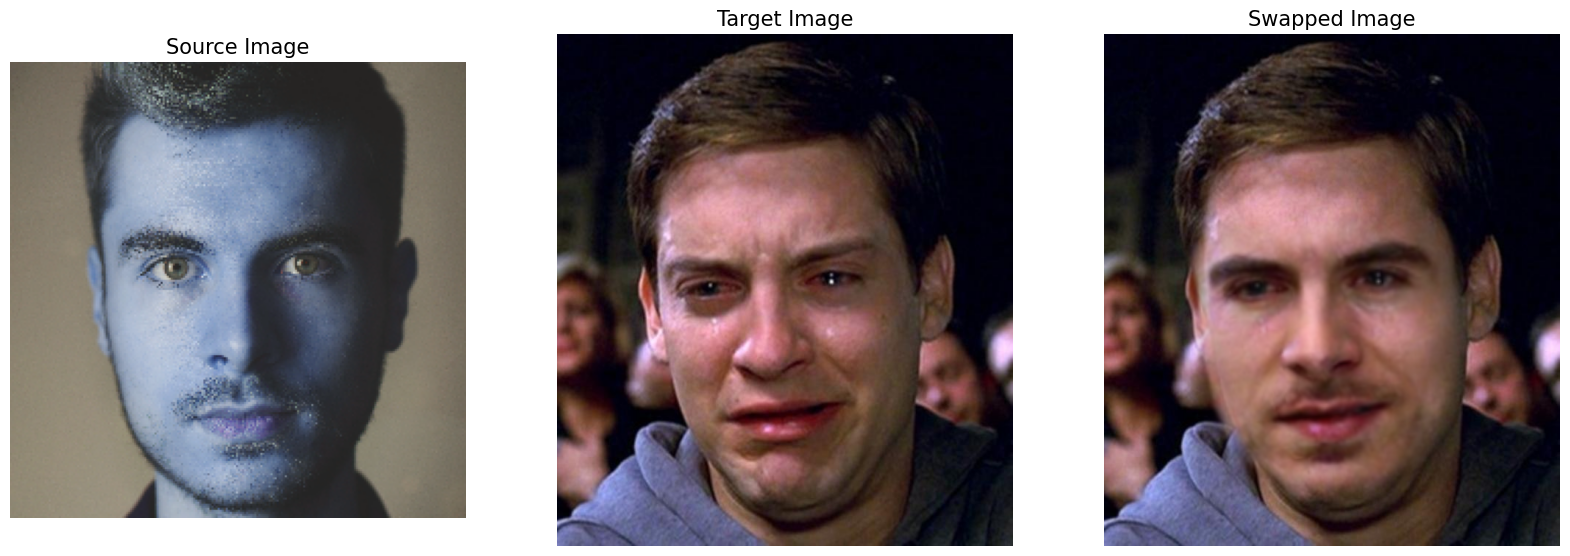

In [1]:
#@markdown #**Preparation**

import cv2
import torch
import time
import os

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions
import warnings
warnings.filterwarnings("ignore")

#@markdown #**Initialize models**

app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('./weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
# G = G.cuda()
# G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
# netArc = netArc.to(torch.device('cpu'))
netArc.load_state_dict(torch.load('./arcface_model/backbone.pth', map_location=torch.device('cpu')))
# put to cpu
# netArc=netArc.cuda()
netArc.eval()

from coordinate_reg.image_infer import Handler
# # model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640, cpu=True)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = False
if use_sr:
    # os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()
    
#@markdown #**Upload source image and video**

#@markdown choose not really long videos, coz it can take a lot of time otherwise

#@markdown choose source image as a photo -- preferable a selfie of a person

target_type = 'image' #@param ["video", "image"]


file_no = '1'

source_path = f'../../dataset/test/{file_no}.jpg' #@param {type:"string"}


# target_path = '../../dataset/first-time.png' #@param {type:"string"}

# data/meme_templates/confused_nick.jpeg
target_path = '../../data/meme_templates/confused_nick.jpeg' #@param {type:"string"}

# data/meme_templates/afraid_to_ask_andy.jpeg
target_path = '../../data/meme_templates/afraid_to_ask_andy.jpeg' #@param {type:"string"}

# data/meme_templates/crying_peter_parker.jpeg
target_path = '../../data/meme_templates/crying_peter_parker.jpeg' #@param {type:"string"}

path_to_video = '' #@param {type:"string"}

source_full = cv2.imread(source_path)
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this


# check, if we can detect face on the source image

try:
    faces = crop_face(source_full, app, crop_size)
    # print(f"Detected {len(faces)} faces")
    
    # source = [f for f in faces if f.shape[0] == max([f.shape[0] for f in faces])][0]
    
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

# read video
if target_type == 'image':
    target_full = cv2.imread(target_path)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

#@markdown #**Inference**


batch_size =  100#@param {type:"integer"}

START_TIME = time.time()

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

if target_type == 'video':
  get_final_video(final_frames_list,
                  crop_frames_list,
                  full_frames,
                  tfm_array_list,
                  OUT_VIDEO_NAME,
                  fps,
                  handler)

  add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

  print(f'Full pipeline took {time.time() - START_TIME}')
  print(f"Video saved with path {OUT_VIDEO_NAME}")
else:
  result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
  cv2.imwrite(f'examples/results/{file_no}result.png', result)
  
  #@markdown #**Visualize Image to Image swap**

import matplotlib.pyplot as plt

show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))


In [6]:
faces[0].shape

(224, 224, 3)

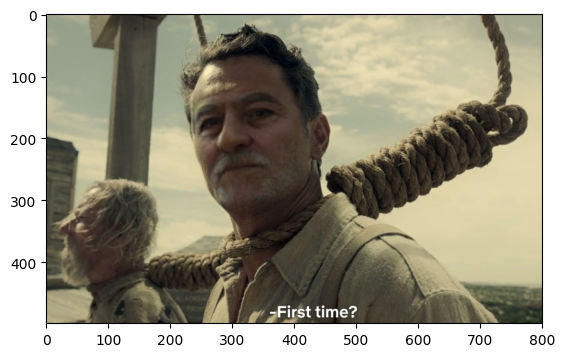

In [44]:
import requests
import cv2
import numpy as np

file_no = '4'

source_path = f'../../dataset/test/{file_no}.jpg' #@param {type:"string"}
target_path = '../../dataset/first-time.png' #@param {type:"string"}

source_full = cv2.imread(source_path)
target_full = cv2.imread(target_path)

url = 'http://localhost:8500/generate_image'

# send post request to the server as files
files = {'source': open(source_path, 'rb'), 'target': open(target_path, 'rb')}
response = requests.post(url, files=files)
response.raise_for_status()

# read the response
result = response.content

# content is a file response, so we need to decode it
result = np.frombuffer(result, np.uint8)


from PIL import Image
from io import BytesIO
result = Image.open(BytesIO(result))

# display the result
plt.imshow(result)

In [30]:
response.content

b'{"result":"Error in captioning image"}'

In [20]:
response.content

# convert bytes to numpy array
result = np.frombuffer(response.content, np.uint8)
result = cv2.imdecode(result, -1)

plt.imshow(result[:, :, ::-1])

TypeError: 'NoneType' object is not subscriptable

In [22]:
result = np.frombuffer(response.content, np.uint8)
result

array([34, 47, 57, ..., 61, 61, 34], dtype=uint8)

In [14]:
# read the response
result = response.content

# decode the response from bytes to numpy array
result = np.frombuffer(result, np.uint8)



# result = cv2.imdecode(np.frombuffer(result, np.uint8), -1)

# show the result
plt.imshow(result[:, :, ::-1])

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [16]:
response.content

b'{"result":"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAHzAyEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2GLbgDf7girkUswAYSEgVSwB0FSJcSIuwdPrUxkoo+V5TSg1WJHAkY5q7FqMLA/P+Fc/5vqgNOjnZXDfhitVWsQ6aOrtdRg+Xc3t1qxJPHNwHGPrXKi/IXHINS2+pSwn5icHoa6FXRlKjzO6Og8uEE/PVu2V

In [15]:
result

array([123,  34, 114, ...,  61,  34, 125], dtype=uint8)

In [12]:
response.content

b'{"result":"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAHzAyEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2GLbgDf7girkUswAYSEgVSwB0FSJcSIuwdPrUxkoo+V5TSg1WJHAkY5q7FqMLA/P+Fc/5vqgNOjnZXDfhitVWsQ6aOrtdRg+Xc3t1qxJPHNwHGPrXKi/IXHINS2+pSwn5icHoa6FXRlKjzO6Og8uEE/PVu2V

In [9]:
# Show result in jupyter notebook
import matplotlib.pyplot as plt

plt.imshow(result[:, :, ::-1])

TypeError: 'NoneType' object is not subscriptable